In [21]:
!pip install remotezip tqdm opencv-python > info.txt
!pip install -q git+https://github.com/tensorflow/docs > info.txt

In [47]:
import tqdm
import random
import pathlib
import itertools
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pevogam/ucf101")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ucf101


In [23]:
import os
import shutil
import random
import pathlib
from collections import defaultdict


def split_ucf_101_subset(dataset_path, class_label_list, splits, output_dir):
    """Create a subset of the UCF101 dataset and split into train, validation, and test sets.
    
    Args:
        dataset_path: Path to the UCF101 dataset (e.g., '/kaggle/input/ucf101')
        class_label_list: list of labels of classes to include in the data
        splits: Dictionary with splits (e.g., {"train": 70, "val": 15, "test": 15})
                Values represent percentages
        output_dir: Directory to save the split datasets
        
    Returns:
        Dictionary mapping split names to their respective directories
    """
    # Ensure output directory exists
    output_dir = pathlib.Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Validate splits percentages
    total_percentage = sum(splits.values())
    if total_percentage != 100:
        raise ValueError(f"Split percentages must sum to 100, got {total_percentage}")
    
    # Find all video files in the dataset
    ucf_dir = os.path.join(dataset_path, "UCF101", "UCF-101")
    if not os.path.exists(ucf_dir):
        raise FileNotFoundError(f"UCF-101 directory not found at {ucf_dir}")
    
    # Get selected classes (directories)
    selected_classes = sorted([d for d in os.listdir(ucf_dir) 
                          if os.path.isdir(os.path.join(ucf_dir, d)) and d in class_label_list])
    
    # # Select subset of classes
    # if num_classes > len(all_classes):
    #     print(f"Warning: Requested {num_classes} classes but only {len(all_classes)} are available.")
    #     selected_classes = all_classes
    # else:
    #     selected_classes = all_classes[:num_classes]
    
    # Collect files for each class
    files_for_class = defaultdict(list)
    for cls in selected_classes:
        class_dir = os.path.join(ucf_dir, cls)
        for video_file in os.listdir(class_dir):
            if video_file.endswith(".avi"):  # UCF-101 videos are in .avi format
                files_for_class[cls].append(os.path.join(class_dir, video_file))
    
    # Shuffle files for each class
    for cls in files_for_class:
        random.shuffle(files_for_class[cls])
    
    # Create output directories for each split
    split_dirs = {}
    for split_name in splits.keys():
        split_dir = output_dir / split_name
        split_dir.mkdir(exist_ok=True)
        split_dirs[split_name] = split_dir
        
        # Create class subdirectories in each split
        for cls in selected_classes:
            os.makedirs(os.path.join(split_dir, cls), exist_ok=True)
    
    # Split files according to percentages and copy to destination
    for cls, files in files_for_class.items():
        total_files = len(files)
        start_idx = 0
        
        for split_name, percentage in splits.items():
            # Calculate number of files for this split
            split_count = int(total_files * percentage / 100)
            
            # Get files for this split
            if split_name == list(splits.keys())[-1]:  # For the last split, take all remaining files
                split_files = files[start_idx:]
            else:
                split_files = files[start_idx:start_idx + split_count]
                start_idx += split_count
            
            # Copy files to destination
            for file in split_files:
                dest_dir = os.path.join(split_dirs[split_name], cls)
                dest_file = os.path.join(dest_dir, os.path.basename(file))
                shutil.copy2(file, dest_file)
            
            print(f"{split_name}: Copied {len(split_files)} files for class {cls}")
    
    return split_dirs


# Example usage:
if __name__ == "__main__":
    DATASET_PATH = "/kaggle/input/ucf101"
    CLASS_LABELS = sorted(['ApplyEyeMakeup', 
                    'PlayingDhol', 
                    'BabyCrawling', 
                    'Haircut', 
                    'SkyDiving',
                   'Surfing', 
                    'Rafting', 
                    'CricketShot', 
                    'ShavingBeard'])
    
    output_dir = pathlib.Path('./UCF101_subset/')
    subset_paths = split_ucf_101_subset(
        dataset_path=DATASET_PATH,
        class_label_list=CLASS_LABELS,
        splits={"train": 70, "val": 15, "test": 15},
        output_dir=output_dir
    )
    
    print("Dataset splits created at:")
    for split_name, split_dir in subset_paths.items():
        print(f"  {split_name}: {split_dir}")

train: Copied 101 files for class ApplyEyeMakeup
val: Copied 21 files for class ApplyEyeMakeup
test: Copied 23 files for class ApplyEyeMakeup
train: Copied 92 files for class BabyCrawling
val: Copied 19 files for class BabyCrawling
test: Copied 21 files for class BabyCrawling
train: Copied 116 files for class CricketShot
val: Copied 25 files for class CricketShot
test: Copied 26 files for class CricketShot
train: Copied 91 files for class Haircut
val: Copied 19 files for class Haircut
test: Copied 20 files for class Haircut
train: Copied 114 files for class PlayingDhol
val: Copied 24 files for class PlayingDhol
test: Copied 26 files for class PlayingDhol
train: Copied 77 files for class Rafting
val: Copied 16 files for class Rafting
test: Copied 18 files for class Rafting
train: Copied 112 files for class ShavingBeard
val: Copied 24 files for class ShavingBeard
test: Copied 25 files for class ShavingBeard
train: Copied 77 files for class SkyDiving
val: Copied 16 files for class SkyDivi

In [24]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame



def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [25]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [26]:
# Create the training set

def get_train_val_test(n_frames=10, batch_size=2):
    output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

    train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)
    val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)
    test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 10),
                                         output_signature = output_signature)

    AUTOTUNE = tf.data.AUTOTUNE
    
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

    train_ds = train_ds.batch(2)
    val_ds = val_ds.batch(2)
    test_ds = test_ds.batch(2)

    return train_ds, val_ds, test_ds

In [27]:
# callbacks to control the learning rate & early stopping
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # or 'loss' if no validation set
    factor=0.5,            # reduce LR by a factor of 0.5
    patience=2,            # wait 2 epochs with no improvement
    verbose=1,             # print updates
    min_lr=1.25e-5            # never go below this
)

def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        return lr * 0.5
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


initial_lr = 1e-3
exp_decay = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss')

In [42]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()


def get_actual_predicted_labels(model, dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted


def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [28]:
import tensorflow as tf

def create_cnn_backbone():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    
    # Define the architecture structure
    filters = [32, 32, 64, 64, 128, 128, 256, 256, 512, 512]
    pooling_indices = [1, 3, 5, 7, 9]  # After which filter to apply pooling
    
    # Start building the network
    x = inputs
    
    # Loop through the filters to build the convolutional blocks
    for i, filter_size in enumerate(filters):
        # Apply Conv2D
        x = tf.keras.layers.Conv2D(filter_size, kernel_size=(3, 3))(x)
        x = tf.keras.layers.ReLU()(x)  # Using ReLU as requested
        x = tf.keras.layers.BatchNormalization()(x)
        
        # Apply MaxPooling after specified layers
        if i in pooling_indices:
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Global Average Pooling at the end
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

def create_video_classification_model(backbone, num_frames=10, num_classes=5):
    """
    Creates a video classification model using the CNN backbone.
    Args:
        num_frames: Number of frames per video sample
        num_classes: Number of output classes
    """
    # Input shape includes time dimension
    inputs = tf.keras.layers.Input(shape=(num_frames, 224, 224, 3))
    
    # Apply the CNN backbone to each frame
    
    x = tf.keras.layers.TimeDistributed(backbone)(inputs)
    
    # Process sequence with LSTM
    x = tf.keras.layers.LSTM(256, return_sequences=False)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.name = 'VIDEO_VGG'
    return model

In [29]:
num_frames = 10
num_classes = len(CLASS_LABELS)
# Create the model
backbone = create_cnn_backbone()
video_model = create_video_classification_model(backbone, num_frames=num_frames, num_classes=num_classes)

# Print model summary
video_model.summary()

# Example of how to compile and use the model
video_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

train_ds, val_ds, test_ds = get_train_val_test()

Model: "VIDEO_VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 10, 224, 224, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 512)             │       4,720,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,541,673 (21.14 MB)

 Trainable params: 5,537,705 (21.12 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [31]:
history = video_model.fit(train_ds, 
          epochs = 20,
          validation_data = val_ds,
          callbacks = [reduce_lr_on_plateau]
        )

Epoch 1/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 59s 116ms/step - accuracy: 0.5360 - loss: 1.3434 - val_accuracy: 0.5588 - val_loss: 1.2425 - learning_rate: 1.0000e-04
Epoch 2/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 59s 116ms/step - accuracy: 0.5480 - loss: 1.2836 - val_accuracy: 0.5919 - val_loss: 1.2260 - learning_rate: 1.0000e-04
Epoch 3/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 59s 116ms/step - accuracy: 0.6266 - loss: 1.0824 - val_accuracy: 0.6287 - val_loss: 1.0528 - learning_rate: 1.0000e-04
Epoch 4/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 60s 117ms/step - accuracy: 0.6851 - loss: 1.0154 - val_accuracy: 0.5588 - val_loss: 1.2652 - learning_rate: 1.0000e-04
Epoch 5/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 59s 116ms/step - accuracy: 0.6847 - loss: 0.9398 - val_accuracy: 0.6618 - val_loss: 0.9611 - learning_rate: 1.0000e-04
Epoch 6/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 60s 117ms/step - accuracy: 0.7088 - loss: 0.8516 - val_accuracy: 0.6176 - val_loss: 1.1306 - learning_rate: 1.0000e-04
Epoch 7/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 59s 11

In [35]:
video_model.save('2d_lstm_vgg_backbone.keras')

In [34]:
loss, accuracy = video_model.evaluate(test_ds)
print(accuracy * 100)

144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - accuracy: 0.8831 - loss: 0.3725
89.93055820465088


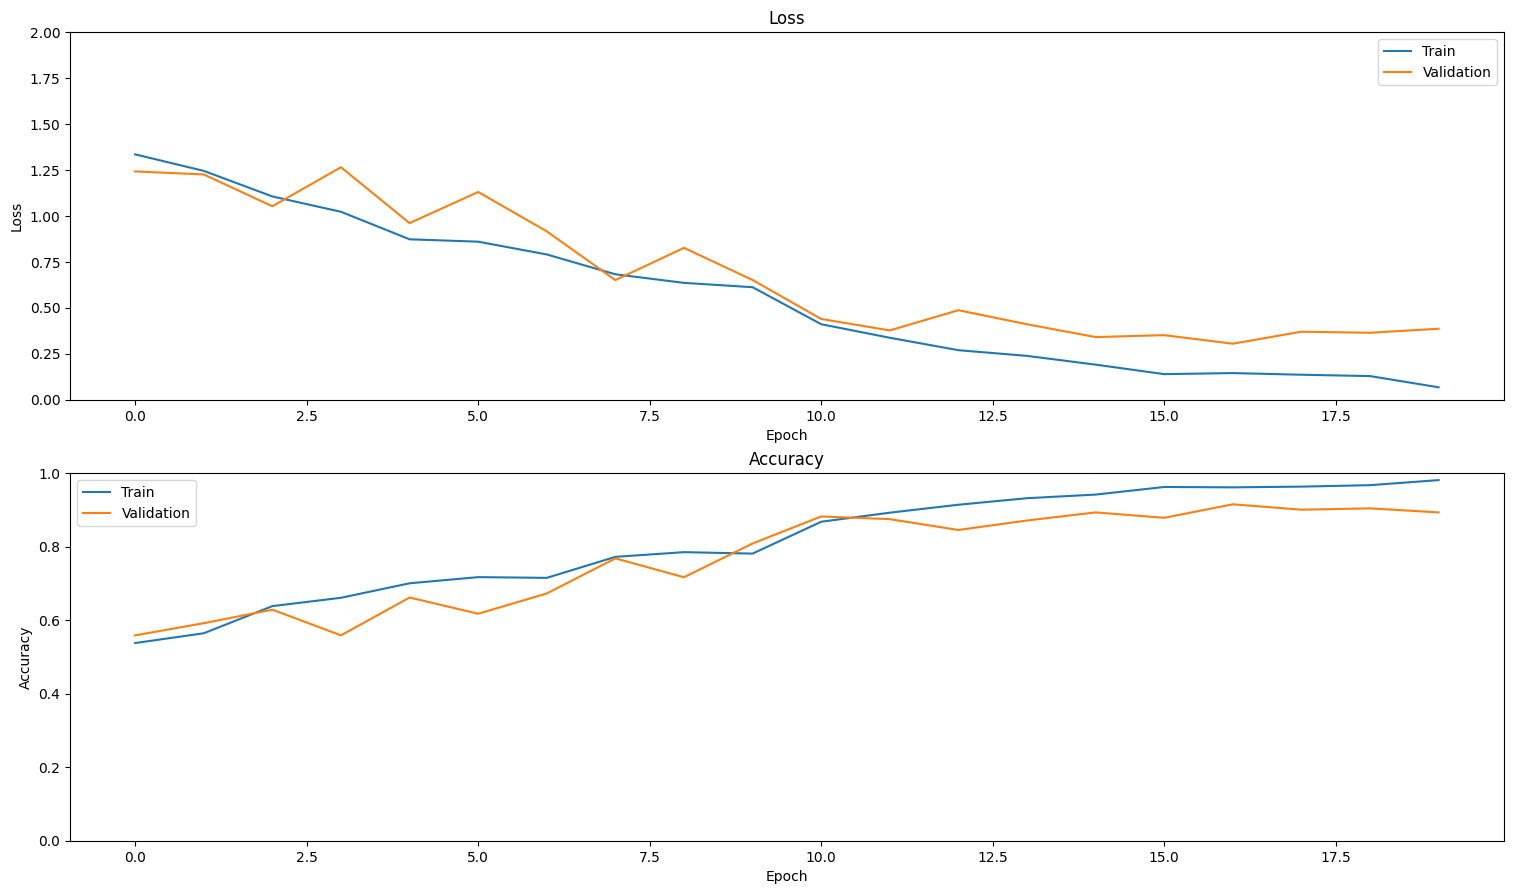

In [39]:
plot_history(history)

508/508 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


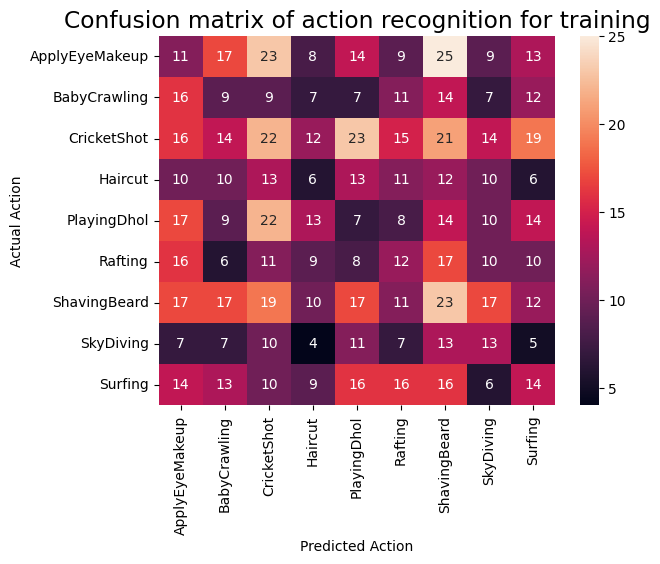

In [48]:
actual, predicted = get_actual_predicted_labels(video_model, train_ds)
plot_confusion_matrix(actual, predicted, CLASS_LABELS, 'training')

144/144 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


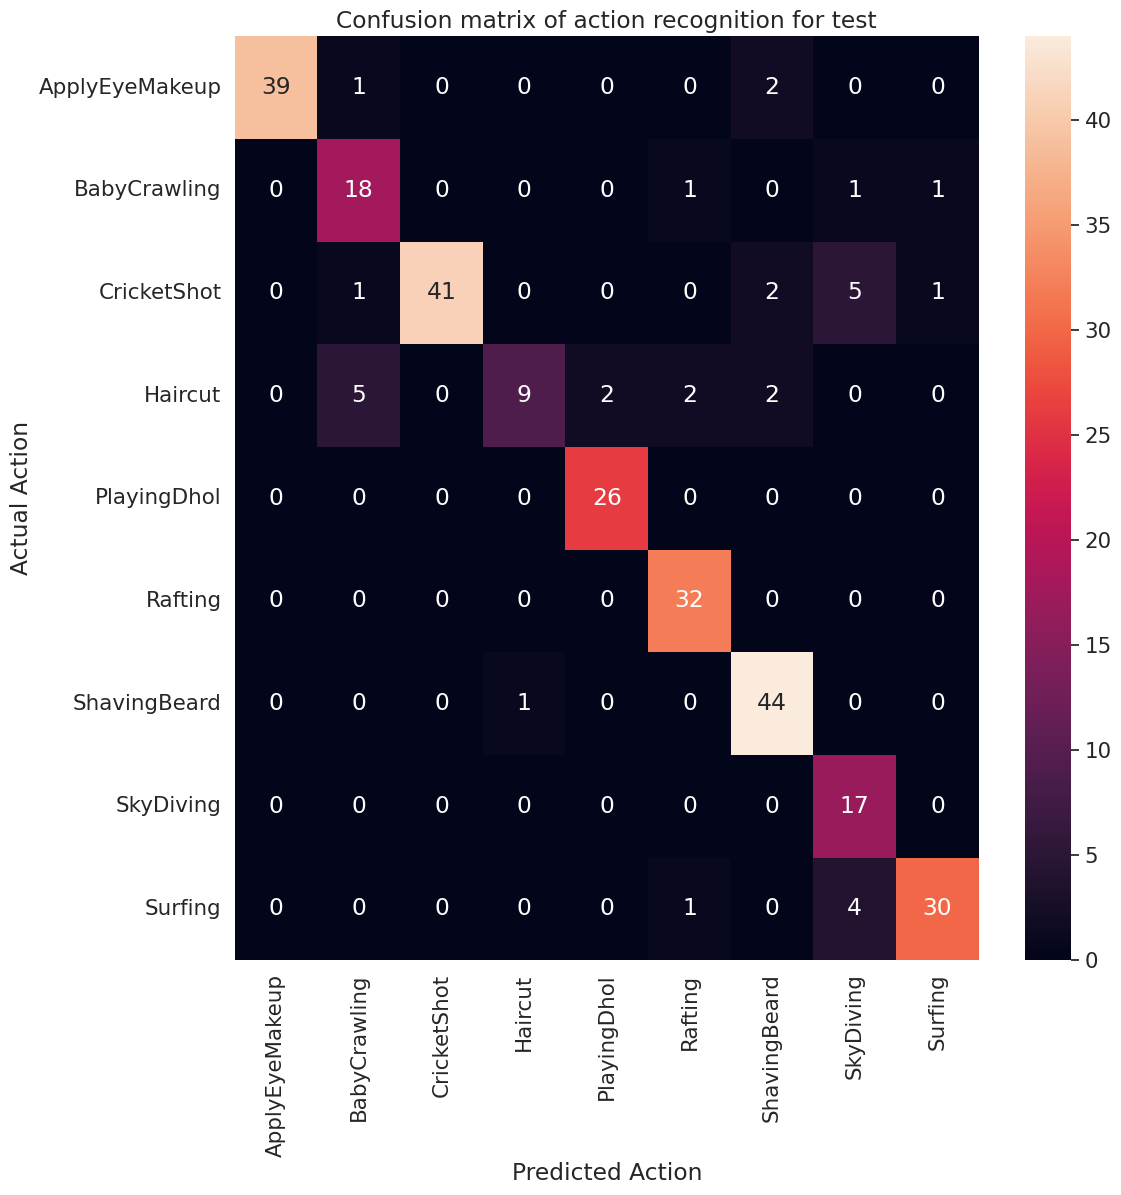

In [50]:
actual, predicted = get_actual_predicted_labels(video_model, test_ds)
plot_confusion_matrix(actual, predicted, CLASS_LABELS, 'test')

In [57]:
import tensorflow as tf
from tensorflow.keras import layers

def residual_block(x, filters, kernel_size=3, stride=1):
    """
    A full residual block with optional projection shortcut if dimensions change.
    
    Args:
        x: input tensor
        filters: number of filters in the conv layers
        kernel_size: size of the convolutional kernel
        stride: stride for the first convolution (useful for downsampling)
    
    Returns:
        Output tensor for the block
    """
    shortcut = x

    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Projection shortcut to match dimensions if needed
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add and activate
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x


inputs = tf.keras.Input(shape=(224, 224, 3))
x = residual_block(inputs, filters=64)
x = residual_block(x, filters=64)
x = residual_block(x, filters=128, stride=2)  # Downsampling
x = layers.GlobalAveragePooling2D()(x)
resnet_backbone = tf.keras.Model(inputs, x)
resnet_backbone.name = 'VIDEO_RESNET'
resnet_model = create_video_classification_model(resnet_backbone, num_frames=10, num_classes=num_classes)
resnet_backbone.summary()
resnet_model.summary()

Model: "VIDEO_RESNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 224, 224, 64)   │          1,728 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_52    │ (None, 224, 224, 64)   │            256 │ conv2d_52[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_44 (ReLU)           │ (None, 224, 224, 64)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 224, 224, 64)   │         36,864 │ re_lu_44[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 224, 224, 64)   │            192 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_53    │ (None, 224, 224, 64)   │            256 │ conv2d_53[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_54    │ (None, 224, 224, 64)   │            256 │ conv2d_54[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 224, 224, 64)   │              0 │ batch_normalization_5… │
│                           │                        │                │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_45 (ReLU)           │ (None, 224, 224, 64)   │              0 │ add_12[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 224, 224, 64)   │         36,864 │ re_lu_45[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_55    │ (None, 224, 224, 64)   │            256 │ conv2d_55[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_46 (ReLU)           │ (None, 224, 224, 64)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 224, 224, 64)   │         36,864 │ re_lu_46[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_56    │ (None, 224, 224, 64)   │            256 │ conv2d_56[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 224, 224, 64)   │              0 │ batch_normalization_5… │
│                      

 Total params: 344,704 (1.31 MB)

 Trainable params: 343,296 (1.31 MB)

 Non-trainable params: 1,408 (5.50 KB)

Model: "VIDEO_VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 10, 224, 224, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 10, 128)             │         344,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 773,001 (2.95 MB)

 Trainable params: 771,593 (2.94 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [60]:
Example of how to compile and use the model
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

train_ds, val_ds, test_ds = get_train_val_test()

history = resnet_model.fit(train_ds, 
          epochs = 20,
          validation_data = val_ds,
          callbacks = [reduce_lr_on_plateau, early_stopping]
        )

Epoch 1/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 167s 328ms/step - accuracy: 0.9085 - loss: 0.2821 - val_accuracy: 0.7647 - val_loss: 0.8111 - learning_rate: 1.2500e-05
Epoch 2/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 167s 330ms/step - accuracy: 0.9018 - loss: 0.3104 - val_accuracy: 0.7647 - val_loss: 0.8000 - learning_rate: 1.2500e-05
Epoch 3/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 167s 328ms/step - accuracy: 0.9036 - loss: 0.2831 - val_accuracy: 0.7610 - val_loss: 0.8380 - learning_rate: 1.2500e-05
Epoch 4/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9100 - loss: 0.2814
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
508/508 ━━━━━━━━━━━━━━━━━━━━ 167s 329ms/step - accuracy: 0.9100 - loss: 0.2814 - val_accuracy: 0.7537 - val_loss: 0.8680 - learning_rate: 1.2500e-05
Epoch 5/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 167s 328ms/step - accuracy: 0.9161 - loss: 0.2364 - val_accuracy: 0.7831 - val_loss: 0.7878 - learning_rate: 6.2500e-06
Epoch 6/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 167s 328

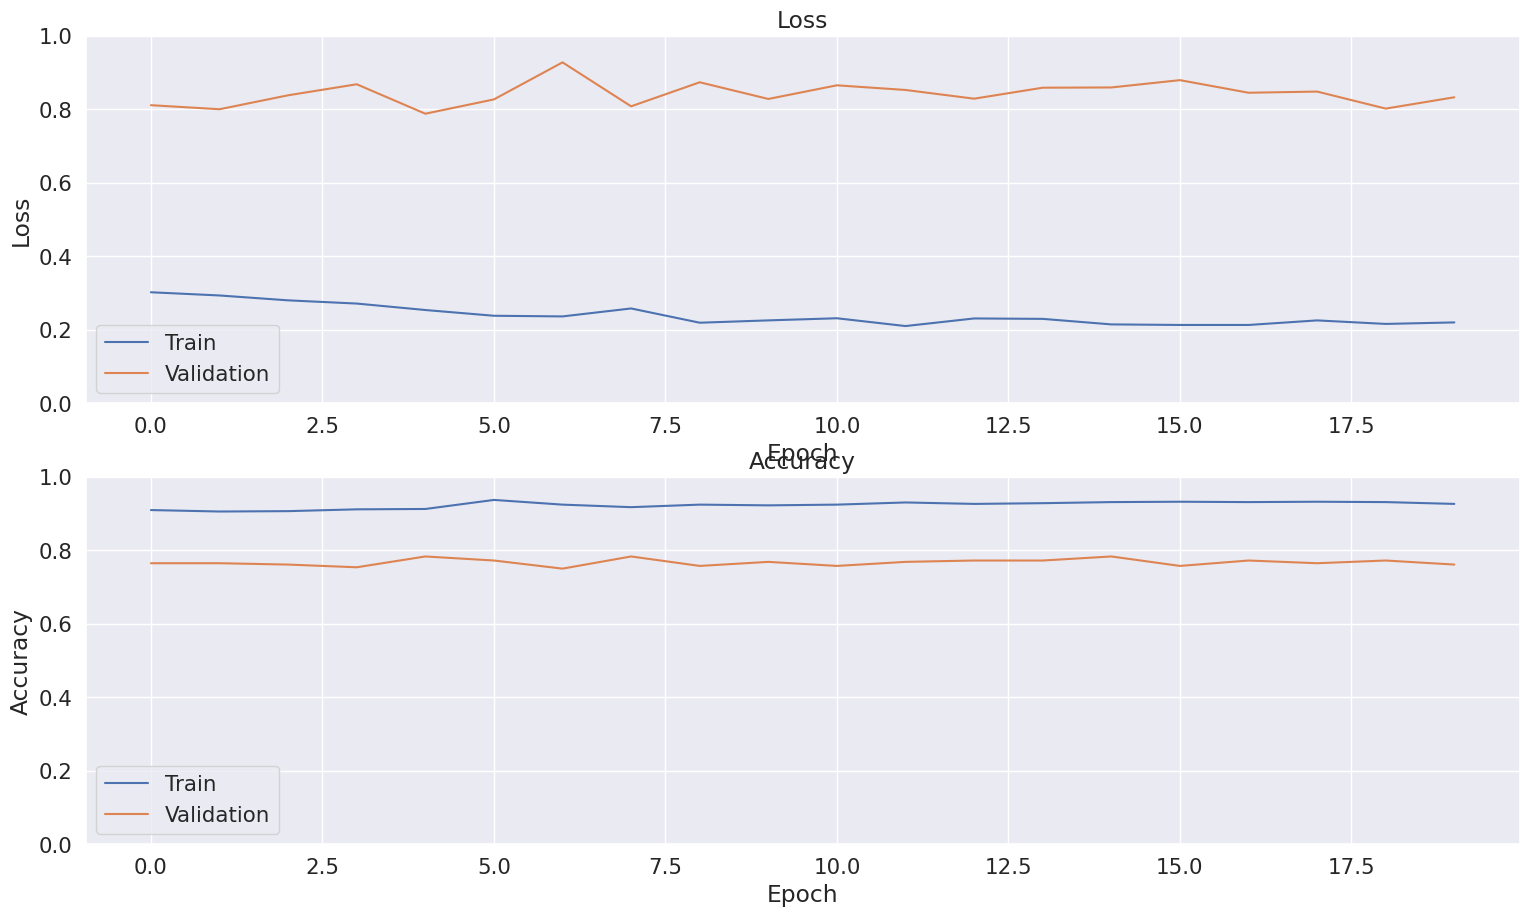

In [61]:
plot_history(history)

In [64]:
loss, accuracy = resnet_model.evaluate(test_ds)
print(accuracy * 100)

144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 248ms/step - accuracy: 0.8223 - loss: 0.4959
77.08333134651184


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


508/508 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step


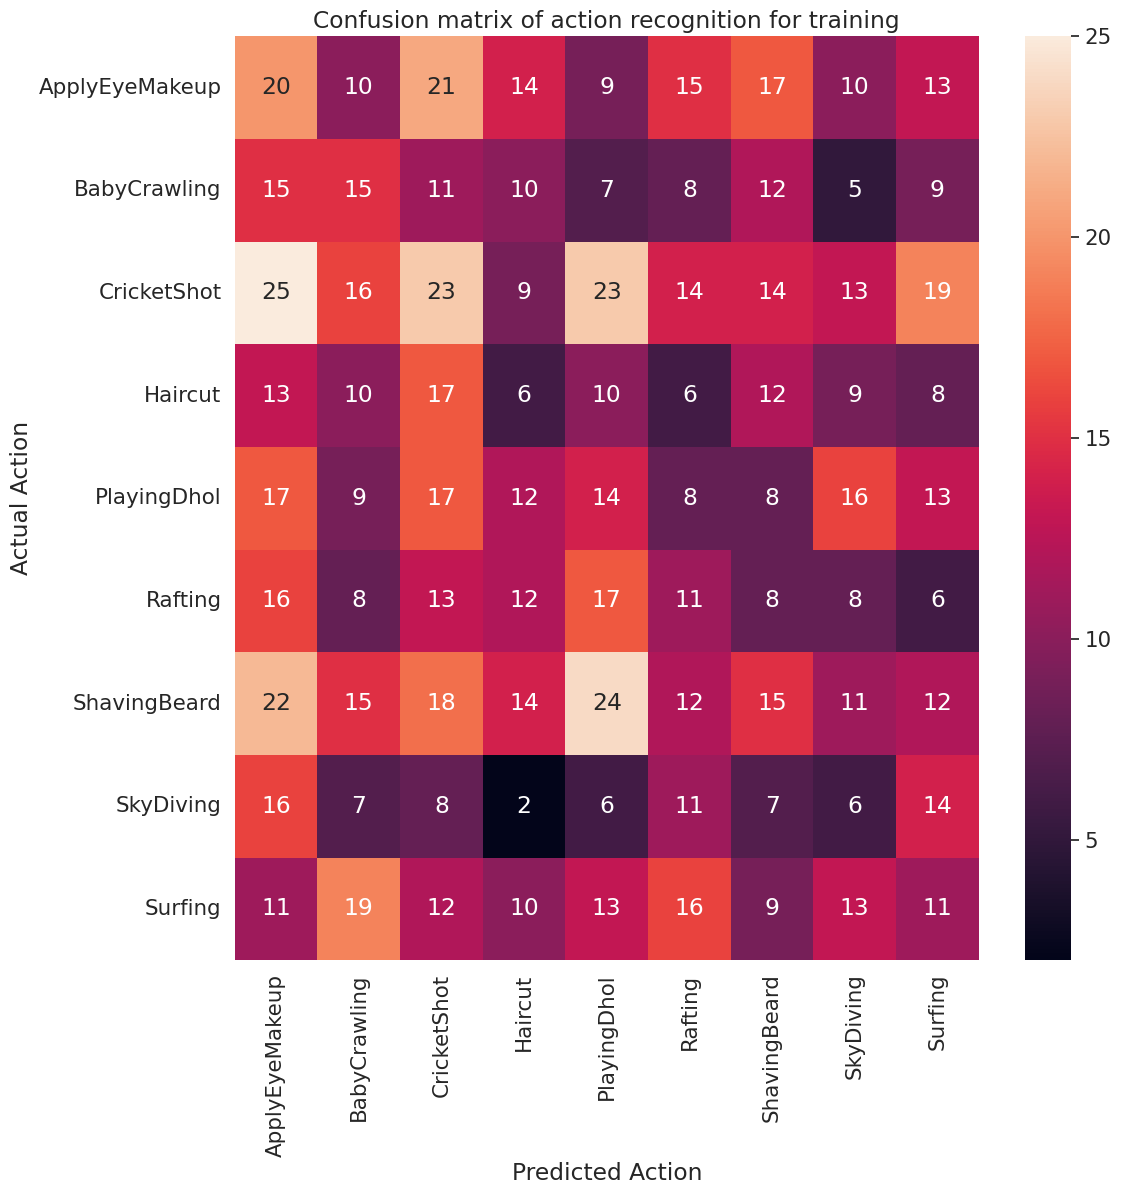

In [62]:
actual, predicted = get_actual_predicted_labels(resnet_model, train_ds)
plot_confusion_matrix(actual, predicted, CLASS_LABELS, 'training')

144/144 ━━━━━━━━━━━━━━━━━━━━ 35s 247ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


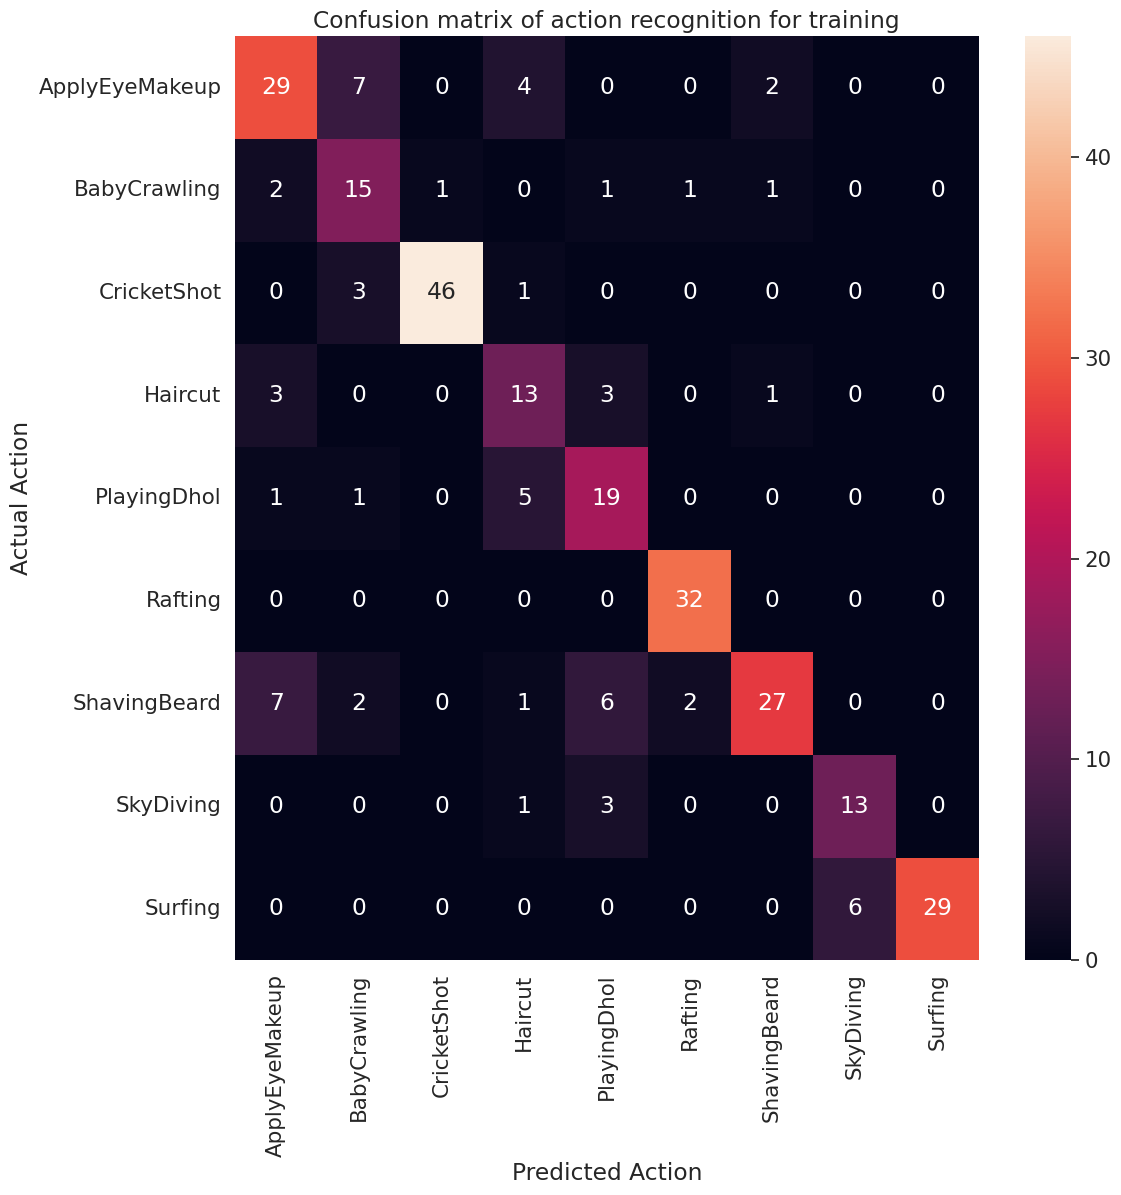

In [63]:
actual, predicted = get_actual_predicted_labels(resnet_model, test_ds)
plot_confusion_matrix(actual, predicted, CLASS_LABELS, 'training')

In [66]:
resnet_model.save('2d_lstm_resnet_backbone.keras')